# Create representative context-specific models - REDS Recall, ATP11C V972M
## Setup
### Import packages

In [ ]:
import re
import shutil
import zipfile
import tempfile
from pathlib import Path
from collections import defaultdict, Counter
from warnings import warn
import gurobipy as gp
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_venn as mpl_venn
import numpy as np
import pandas as pd
import seaborn as sns
import sympy
from rbc_gem_utils import (
    COBRA_CONFIGURATION,
    get_dirpath,
    read_cobra_model,
    show_versions,
    write_cobra_model,
    handle_msg,
)
from rbc_gem_utils.analysis.overlay import (
    DEFAULT_PREFIX_SUFFIX_VALUES,
    ProteinDilution,
    add_relaxation_budget,
    load_overlay_model,
    update_slack_value,
    create_protein_dilution_df,
)
from rbc_gem_utils.util import AVOGADRO_NUMBER
from sklearn.metrics import r2_score

gp.setParam("OutputFlag", 0)
gp.setParam("LogToConsole", 0)

# Show versions of notebook
show_versions()

Set parameter Username
Set parameter LicenseID to value 2664191
Academic license - for non-commercial use only - expires 2026-05-12

Package Information
-------------------
rbc-gem-utils 0.0.3

Dependency Information
----------------------
beautifulsoup4                       4.13.4
bio                                   1.8.0
cobra                                0.29.1
depinfo                               2.2.0
gurobipy                             12.0.3
matplotlib                           3.10.3
matplotlib-venn                       1.1.2
memote                               0.17.0
networkx                                3.5
notebook                              7.4.4
openpyxl                              3.1.5
pandas                                2.3.1
pre-commit                            4.2.0
rbc-gem-utils[database,network,vis] missing
requests                             2.32.4
scikit-learn                          1.7.0
scipy                                1.16.0
seaborn     

### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION.solver = "gurobi"
# Set bound defaults much larger to prevent model loading issues
COBRA_CONFIGURATION.bounds = (-1e-8, 1e8)
COBRA_CONFIGURATION.tolerance = 1e-9
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-09
lower_bound,Default reaction lower bound,-1e-08
upper_bound,Default reaction upper bound,100000000.0
processes,Number of parallel processes,127
cache_directory,Path for the model cache,C:\Users\P7875\AppData\Local\opencobra\cobrapy\Cache
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


### Define organism, model, and dataset

In [3]:
organism = "Human"
model_id = "RBC_GEM"
dataset_name = "REDSRecall"
genotype = "ATP11C_V972M"
grouped_data_key = f'{genotype}_Sample' 
grouped_data_key

'ATP11C_V972M_Sample'

### Set variables for columns keys and sample identification

In [4]:
sample_key = "SAMPLE ID"
donor_key = "PUBLIC RECALL DONOR ID"

# For sample IDs
donor_re = re.compile(rf"(?P<donor>S(?P<num>\d\d\d))")
operations = "|".join([x.capitalize() for x in ["mean", "median"]])
operation_re = re.compile(r"(?P<op>" + operations + r")\_(?P<group>\w+)")
sample_id_re = re.compile(
    r"(?!" + operations + r")" + donor_re.pattern + r"\_"
)

### Set computation options

In [5]:
run_computations = True  # Keep off to use previously computed results
overwrite = True  # Whether to allow overwriting of previous simulation results
verbose = True
objective_reactions = [] # Objective reactions are used to determine slack variable but not necessary

### Set figure options

In [6]:
save_figures = True
transparent = False
imagetype = "svg"

### Set paths

In [7]:
# Set paths
processed_clusters_dirpath = get_dirpath(use_temp="processed") / model_id / "Clustering" / organism / dataset_name
processed_data_dirpath = get_dirpath(use_temp="processed") / organism / dataset_name
overlay_dirpath = get_dirpath("analysis") / "OVERLAY" / organism
model_dirpath = overlay_dirpath / model_id
results_dirpath = (get_dirpath(use_temp="processed") / model_id / "OVERLAY" / organism / dataset_name / grouped_data_key)
fitting_dirpath = results_dirpath / "fitting"
# Ensure directories exist
results_dirpath.mkdir(exist_ok=True, parents=True)
fitting_dirpath.mkdir(exist_ok=True, parents=True)
# ZIP directories
sample_pcmodels_dirpath = results_dirpath / "pcmodels"

### Define hemoglobin proteins

In [8]:
HB_PROTEINS = {
    "HBA": "P69905",  # Hemoglobin subunit alpha
    "HBB": "P68871",  # Hemoglobin subunit beta
    "HBD": "P02042",  # Hemoglobin subunit delta
    "HBE1": "P02100",  # Hemoglobin subunit beta
    "HBG1": "P69891",  # Hemoglobin subunit gamma-1
    "HBG2": "P69892",  # Hemoglobin subunit gamma-2
    "HBM": "Q6B0K9",  # Hemoglobin subunit mu
    "HBQ1": "P09105",  # Hemoglobin subunit theta-1
    "HBZ": "P02008",  # Hemoglobin subunit zeta
}

## Load RBC-GEM model

In [9]:
# Load models
model = read_cobra_model(filename=model_dirpath / f"{model_id}.xml")
pcmodel = load_overlay_model(filename=model_dirpath / f"{model_id}_PC.xml")

pcmodel

Name,RBC_GEM_PC
Memory address,1fa4f1c2910
Number of metabolites,7814
Number of reactions,14963
Number of genes,723
Number of groups,68
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space, protein compartment"


## Load copy numbers and protein data

In [10]:
# Load protein copy numbers
df_copy_numbers = pd.read_csv(
    processed_clusters_dirpath / genotype / f"{grouped_data_key}_ClusterCopyNumbers.csv",
    index_col=0,
)

# Load MCH for transforming data
df_MCH = pd.read_csv(
    processed_clusters_dirpath / genotype / f"{grouped_data_key}_ClusterMCH.csv",
    index_col=0
)

# Load protein data
df_protein_data = pd.read_csv(
    processed_data_dirpath / "ProteinData.csv",
    index_col="Entry",
)

all_ids = list(df_copy_numbers.index.unique())
operation_ids = [x for x in all_ids if operation_re.match(x)]
sample_ids = [x for x in all_ids if not operation_re.match(x)]

handle_msg(f"Number of measured samples: {len(sample_ids)}", print_msg=True)
handle_msg(f"Number of operation samples: {len(operation_ids)}", print_msg=True)
handle_msg(f"Number of models to generate: {len(all_ids)}", print_msg=True)

Number of measured samples: 32
Number of operation samples: 6
Number of models to generate: 38


## Integrate proteomics with model
### Scale measurements for proteome budget
Note that this step will help ensure its theoretically possible for a perfect fit 

In [11]:
HB_PERCENT, LA_PERCENT = (0.95, 0.05)
MODELED_PERCENT = HB_PERCENT + LA_PERCENT
assert 1 >= MODELED_PERCENT

budget_hb_value = 1000 * HB_PERCENT
budget_la_value = 1000 * LA_PERCENT
budget_total_value = 1000 * MODELED_PERCENT

handle_msg(f"Hemoglobin budget:\t{budget_hb_value} mg protein / gDW", print_msg=True)
handle_msg(f"Low abundance budget:\t{budget_la_value} mg protein / gDW", print_msg=True)
handle_msg(f"Total budget:\t\t{budget_total_value} mg protein / gDW", print_msg=True)

Hemoglobin budget:	950.0 mg protein / gDW
Low abundance budget:	50.0 mg protein / gDW
Total budget:		1000.0 mg protein / gDW


### Convert copy numbers to mg / gDW

In [12]:
df_uniprot_to_mw = df_protein_data["Mass"].astype(float)

gDW_total_protein = (
    df_MCH             # pgDW HB
    * (1 / HB_PERCENT) # pgDW total protein / pgDW HB
    * (1  / 1e12)      #  gDW total protein / pgDW total protein
) # gDW total protein / cell
df_mg_prot_per_gDW = df_copy_numbers[df_protein_data.index].mul( # protein copies / cell
    1 / gDW_total_protein.squeeze(), # cell / gDW total protein
    axis=0
) * (
    1 / AVOGADRO_NUMBER  # mol protein / protein copies
    * df_uniprot_to_mw   # gDW protein / mol protein
    * 1e3                # mgDW protein / gDW protein
).copy() # mgDW protein / gDW total protein
df_mg_prot_per_gDW = df_mg_prot_per_gDW.loc[df_copy_numbers.index]
df_mg_prot_per_gDW[df_mg_prot_per_gDW.index.duplicated()]

,A0A075B6I0,A0A075B6I9,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6R2,A0A075B6S5,A0A075B6S9,A0A087WSY6,A0A0A0MRZ8,...,Q9Y639,Q9Y666,Q9Y696,Q9Y6B6,Q9Y6B7,Q9Y6E0,Q9Y6I3,Q9Y6M4,Q9Y6M5,Q9Y6R7


In [13]:
# Split into hemoglobin and low abundance proteomes
budget_rxn_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["budgets"]["prefix.dilution"]
budget_met_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["budgets"]["prefix.metabolite"]
df_mg_prot_per_gDW_hb = df_mg_prot_per_gDW.loc[
    :, df_mg_prot_per_gDW.columns.isin(HB_PROTEINS.values())
]
df_mg_prot_per_gDW_la = df_mg_prot_per_gDW.loc[
    :, ~df_mg_prot_per_gDW.columns.isin(HB_PROTEINS.values())
]

df_summary = {
    "Perfect total": 1000,
    "Current total": df_mg_prot_per_gDW.loc[sample_ids].sum(axis=1).mean().item(),
    "Hemoglobin total": df_mg_prot_per_gDW_hb.loc[sample_ids].sum(axis=1).mean().item(),
    "Low abundance total": df_mg_prot_per_gDW_la.loc[sample_ids]
    .sum(axis=1)
    .mean()
    .item(),
}
df_summary["Remaining/Excess"] = df_summary["Perfect total"] - (
    df_summary["Hemoglobin total"] + df_summary["Low abundance total"]
)

budget_rxn_proteome = pcmodel.reactions.get_by_id(
    f"{budget_rxn_prefix}{budget_met_prefix}proteome"
)
budget_rxn_hemoglobin = pcmodel.reactions.get_by_id(
    f"{budget_rxn_prefix}{budget_met_prefix}hemoglobin"
)
budget_rxn_total = pcmodel.reactions.get_by_id(
    f"{budget_rxn_prefix}{budget_met_prefix}total"
)

if budget_la_value is None:
    budget_la_value = budget_rxn_proteome.upper_bound
if budget_hb_value is None:
    budget_hb_value = budget_rxn_hemoglobin.upper_bound
if budget_total_value is None:
    budget_total_value = budget_rxn_total.upper_bound

assert budget_total_value >= (budget_la_value + budget_hb_value)

budget_rxn_proteome.upper_bound = budget_la_value
budget_rxn_hemoglobin.upper_bound = budget_hb_value
budget_rxn_total.upper_bound = budget_total_value

# Scale values for low abundance proteome
budget_value = budget_la_value
df_mg_prot_per_gDW_la = (
    budget_value * (df_mg_prot_per_gDW_la.T / df_mg_prot_per_gDW_la.sum(axis=1)).T
)
df_summary["Low abundance scaled"] = budget_value

# Scale values for hemoglobin proteome
budget_value = budget_hb_value
df_mg_prot_per_gDW_hb = (
    budget_value * (df_mg_prot_per_gDW_hb.T / df_mg_prot_per_gDW_hb.sum(axis=1)).T
)
df_summary["Hemoglobin scaled"] = budget_value

budget_value = budget_total_value - sum(
    [budget_la_value, budget_hb_value]
)
df_summary["Remaining scaled"] = budget_value

# Combine dataframes back into one
df_mg_prot_per_gDW_normalized = pd.concat(
    (df_mg_prot_per_gDW_hb, df_mg_prot_per_gDW_la), axis=1
)
df_summary = pd.DataFrame.from_dict(
    {
        " " * max(30 - len(k), 0) + k: [f"{v:.4f}", f"{v / 1000 * 100:.1f}%"]
        for k, v in df_summary.items()
    },
    orient="index",
    columns=["mg protein / gDW / cell", "Percentage"],
)
print(df_summary)
df_mg_prot_per_gDW_normalized.sum(axis=1)

                     mg protein / gDW / cell Percentage
       Perfect total               1000.0000     100.0%
       Current total               1000.0000     100.0%
    Hemoglobin total                431.9018      43.2%
 Low abundance total                568.0982      56.8%
    Remaining/Excess                  0.0000       0.0%
Low abundance scaled                 50.0000       5.0%
   Hemoglobin scaled                950.0000      95.0%
    Remaining scaled                  0.0000       0.0%


Allele0_C0          1000.0
Allele0_C1          1000.0
Allele0_C2          1000.0
Allele0_C3          1000.0
Allele0_C4          1000.0
Allele0_C5          1000.0
Allele0_C6          1000.0
Allele0_C7          1000.0
Allele0_C8          1000.0
Allele0_C9          1000.0
Allele0_C10         1000.0
Allele0_C11         1000.0
Allele0_C12         1000.0
Allele0_C13         1000.0
Allele0_C14         1000.0
Allele0_C15         1000.0
Allele0_C16         1000.0
Allele0_C17         1000.0
Allele1_C18         1000.0
Allele1_C19         1000.0
Allele1_C20         1000.0
Allele1_C21         1000.0
Allele1_C22         1000.0
Allele1_C23         1000.0
Allele1_C24         1000.0
Allele1_C25         1000.0
Allele2_S379_D10    1000.0
Allele2_S379_D23    1000.0
Allele2_S379_D42    1000.0
Allele2_S417_D10    1000.0
Allele2_S417_D23    1000.0
Allele2_S417_D42    1000.0
Mean_Allele0        1000.0
Mean_Allele1        1000.0
Mean_Allele2        1000.0
Median_Allele0      1000.0
Median_Allele1      1000.0
M

### Convert mg / gDW to nmol / gDW

In [14]:
df_nmol_prot_per_gDW = (
    df_mg_prot_per_gDW_normalized  # mg / gDW
    * (1 / df_uniprot_to_mw)  # mol / g --> mmol / mg
    * (1e6 / 1)  # nmol / mmol
).loc[:, df_mg_prot_per_gDW_normalized.columns]
df_nmol_prot_per_gDW = df_nmol_prot_per_gDW.T
df_nmol_prot_per_gDW

,Allele0_C0,Allele0_C1,Allele0_C2,Allele0_C3,Allele0_C4,Allele0_C5,Allele0_C6,Allele0_C7,Allele0_C8,Allele0_C9,...,Allele2_S379_D42,Allele2_S417_D10,Allele2_S417_D23,Allele2_S417_D42,Mean_Allele0,Mean_Allele1,Mean_Allele2,Median_Allele0,Median_Allele1,Median_Allele2
P02008,6522.512719,7407.366134,6744.957260,2300.995641,6566.386212,8274.873638,6993.474096,7940.225143,7239.764954,8281.853542,...,8205.894950,7158.743015,7861.339911,7198.686781,6975.134553,7032.151111,7553.784352,7433.423437,7486.503091,7434.470190
P02042,25500.307617,23729.372329,20980.015583,22459.944301,26969.780710,22843.055719,25570.248067,28230.440662,24751.074927,24269.149737,...,22504.415443,28653.645235,26961.036355,29640.481964,24480.693483,24718.645669,26203.777072,24285.111874,24464.515295,26779.554877
P02100,16.999290,9.528515,7.111785,45.443139,29.920188,13.990757,31.490525,122.374415,17.773348,18.936888,...,5.406964,8.392571,14.613915,16.003602,31.247664,43.357279,10.617303,19.583292,27.852954,11.224232
P09105,38.616261,39.053967,34.373962,39.302226,41.082762,38.254573,48.974217,51.171281,43.025303,39.115873,...,38.055394,37.157539,45.591261,36.873105,41.556992,49.004875,36.241529,40.944666,45.788897,35.417241
P68871,9784.662638,10449.230599,10150.207339,15319.744121,10032.510233,9912.752885,10435.468316,7748.796711,10636.406016,10064.756100,...,11663.947284,9550.236665,10062.441717,9332.005336,10365.190460,10288.921497,10598.102543,10288.721588,10239.488425,9911.783739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6E0,0.051973,0.056545,0.044131,0.043636,0.061556,0.049026,0.052402,0.068388,0.062682,0.055646,...,0.057720,0.055630,0.040086,0.062156,0.054614,0.058887,0.048780,0.055509,0.061206,0.050684
Q9Y6I3,0.027373,0.016758,0.025365,0.026329,0.009570,0.020507,0.016007,0.006451,0.020499,0.017593,...,0.039596,0.011520,0.000000,0.038231,0.017880,0.017717,0.016569,0.017974,0.013218,0.009119
Q9Y6M4,0.170732,0.223695,0.102062,0.080754,0.112599,0.166558,0.132368,0.021883,0.097835,0.162146,...,0.000000,0.000000,0.000000,0.000000,0.129194,0.159199,0.830115,0.141582,0.134274,0.000000
Q9Y6M5,0.063199,0.060301,0.049095,0.044918,0.072786,0.059862,0.058380,0.072993,0.064090,0.068497,...,0.047692,0.070435,0.032061,0.065923,0.058509,0.060122,0.069714,0.060602,0.060513,0.062330


## Create DataFrame for protein dilution reactions

In [15]:
df_model_protein_dilutions = create_protein_dilution_df(pcmodel)
df_model_protein_dilutions

,genes,PROTDL
uniprot,,
Q9NRN7,AASDHPPT,PROTDL_protein_AASDHPPT_pc
O95477,ABCA1,PROTDL_protein_ABCA1_pc
Q8IZY2,ABCA7,PROTDL_protein_ABCA7_pc
P08183,ABCB1,PROTDL_protein_ABCB1_pc
P21439,ABCB4,PROTDL_protein_ABCB4_pc
...,...,...
P07947,YES1,PROTDL_protein_YES1_pc
Q5W0Z9,ZDHHC20,PROTDL_protein_ZDHHC20_pc
Q9UIJ5,ZDHHC2,PROTDL_protein_ZDHHC2_pc


## Organize samples (optional)
Use this for organizing samples if time-outs are an issue or multiple runs are necessary

In [16]:
df_samples = df_nmol_prot_per_gDW.copy()
df_samples

,Allele0_C0,Allele0_C1,Allele0_C2,Allele0_C3,Allele0_C4,Allele0_C5,Allele0_C6,Allele0_C7,Allele0_C8,Allele0_C9,...,Allele2_S379_D42,Allele2_S417_D10,Allele2_S417_D23,Allele2_S417_D42,Mean_Allele0,Mean_Allele1,Mean_Allele2,Median_Allele0,Median_Allele1,Median_Allele2
P02008,6522.512719,7407.366134,6744.957260,2300.995641,6566.386212,8274.873638,6993.474096,7940.225143,7239.764954,8281.853542,...,8205.894950,7158.743015,7861.339911,7198.686781,6975.134553,7032.151111,7553.784352,7433.423437,7486.503091,7434.470190
P02042,25500.307617,23729.372329,20980.015583,22459.944301,26969.780710,22843.055719,25570.248067,28230.440662,24751.074927,24269.149737,...,22504.415443,28653.645235,26961.036355,29640.481964,24480.693483,24718.645669,26203.777072,24285.111874,24464.515295,26779.554877
P02100,16.999290,9.528515,7.111785,45.443139,29.920188,13.990757,31.490525,122.374415,17.773348,18.936888,...,5.406964,8.392571,14.613915,16.003602,31.247664,43.357279,10.617303,19.583292,27.852954,11.224232
P09105,38.616261,39.053967,34.373962,39.302226,41.082762,38.254573,48.974217,51.171281,43.025303,39.115873,...,38.055394,37.157539,45.591261,36.873105,41.556992,49.004875,36.241529,40.944666,45.788897,35.417241
P68871,9784.662638,10449.230599,10150.207339,15319.744121,10032.510233,9912.752885,10435.468316,7748.796711,10636.406016,10064.756100,...,11663.947284,9550.236665,10062.441717,9332.005336,10365.190460,10288.921497,10598.102543,10288.721588,10239.488425,9911.783739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6E0,0.051973,0.056545,0.044131,0.043636,0.061556,0.049026,0.052402,0.068388,0.062682,0.055646,...,0.057720,0.055630,0.040086,0.062156,0.054614,0.058887,0.048780,0.055509,0.061206,0.050684
Q9Y6I3,0.027373,0.016758,0.025365,0.026329,0.009570,0.020507,0.016007,0.006451,0.020499,0.017593,...,0.039596,0.011520,0.000000,0.038231,0.017880,0.017717,0.016569,0.017974,0.013218,0.009119
Q9Y6M4,0.170732,0.223695,0.102062,0.080754,0.112599,0.166558,0.132368,0.021883,0.097835,0.162146,...,0.000000,0.000000,0.000000,0.000000,0.129194,0.159199,0.830115,0.141582,0.134274,0.000000
Q9Y6M5,0.063199,0.060301,0.049095,0.044918,0.072786,0.059862,0.058380,0.072993,0.064090,0.068497,...,0.047692,0.070435,0.032061,0.065923,0.058509,0.060122,0.069714,0.060602,0.060513,0.062330


### Map samples to model

In [17]:
merge_key = "uniprot"
df_samples.index.name = merge_key

df_model = (
    df_model_protein_dilutions[["PROTDL"]]
    .merge(df_samples, left_index=True, right_index=True, how="left")
    .set_index("PROTDL")
    .sort_index()
)
no_experimental_measurements = [
    protein_dilution
    for protein_dilution, has_measurement in df_model.isna().all(axis=1).items()
    if has_measurement
]
handle_msg(f"Model proteins mapped to measurements: {len(df_model) - len(no_experimental_measurements)}", print_msg=True)
handle_msg(f"Model proteins without measurements: {len(no_experimental_measurements)}", print_msg=True)
df_model.dropna()

Model proteins mapped to measurements: 455
Model proteins without measurements: 268


,Allele0_C0,Allele0_C1,Allele0_C2,Allele0_C3,Allele0_C4,Allele0_C5,Allele0_C6,Allele0_C7,Allele0_C8,Allele0_C9,...,Allele2_S379_D42,Allele2_S417_D10,Allele2_S417_D23,Allele2_S417_D42,Mean_Allele0,Mean_Allele1,Mean_Allele2,Median_Allele0,Median_Allele1,Median_Allele2
PROTDL,,,,,,,,,,,,,,,,,,,,,
PROTDL_protein_AASDHPPT_pc,0.007543,0.005924,0.063772,0.002860,0.001012,0.008824,0.005153,0.000236,0.001608,0.002531,...,0.000000,0.000000,0.000000,0.000000,0.010758,0.009415,0.003576,0.003516,0.000389,0.000000
PROTDL_protein_ABCB6_pc,0.166365,0.171381,0.131241,0.133720,0.171389,0.134606,0.185652,0.110502,0.141999,0.160015,...,0.144901,0.167991,0.184451,0.143534,0.139346,0.142056,0.169072,0.141742,0.142197,0.163428
PROTDL_protein_ABCC1_pc,0.027397,0.025381,0.021481,0.017822,0.009194,0.026047,0.024533,0.009557,0.034603,0.028828,...,0.034482,0.000000,0.018296,0.016417,0.022163,0.017956,0.014853,0.024411,0.021176,0.016156
PROTDL_protein_ABCC4_pc,0.051885,0.057466,0.048473,0.048474,0.060711,0.052708,0.064587,0.060780,0.053458,0.059404,...,0.059602,0.048390,0.055106,0.059915,0.053598,0.071236,0.059418,0.055824,0.073458,0.060364
PROTDL_protein_ABCC5_pc,0.009422,0.003236,0.006681,0.004647,0.002926,0.004709,0.006382,0.002694,0.003591,0.004952,...,0.000000,0.000000,0.000000,0.000000,0.004694,0.004355,0.000578,0.004668,0.004387,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PROTDL_protein_VDAC3_pc,0.029124,0.066879,0.037921,0.016685,0.060553,0.025670,0.044125,0.021801,0.093812,0.053437,...,0.000000,0.000000,0.000000,0.000000,0.038101,0.109750,0.046075,0.035250,0.134771,0.000000
PROTDL_protein_VPS4A_pc,0.054870,0.057590,0.032927,0.052747,0.085061,0.048100,0.065649,0.080343,0.050860,0.058029,...,0.272048,0.085843,0.068169,0.070558,0.054601,0.050810,0.112269,0.056241,0.054413,0.074861
PROTDL_protein_WDR77_pc,0.438665,0.489109,0.511181,0.484638,0.435880,0.482470,0.425308,0.486626,0.473780,0.494316,...,0.316907,0.486063,0.315743,0.324106,0.467056,0.500068,0.366650,0.472563,0.481187,0.356492


#### Summarize mapping

In [18]:
dataset_proteins = set(df_samples.index)
model_proteins = set(df_model_protein_dilutions.index)

df_mg_prot_per_gDW_hb = df_mg_prot_per_gDW_normalized.loc[
    [
        x for x in df_mg_prot_per_gDW_normalized.index if x in sample_ids
    ],  # Don't include operation IDs
    [
        x
        for x in df_mg_prot_per_gDW_normalized.columns
        if x in list(HB_PROTEINS.values())
    ],
]
df_mg_prot_per_gDW_la = df_mg_prot_per_gDW_normalized.loc[
    [
        x for x in df_mg_prot_per_gDW_normalized.index if x in sample_ids
    ],  # Don't include operation IDs
    [
        x
        for x in df_mg_prot_per_gDW.columns
        if not x in list(HB_PROTEINS.values())
    ],
]

df_mapped_mass_la = df_mg_prot_per_gDW_la.loc[
    :, df_mg_prot_per_gDW_la.columns.isin(model_proteins)
].sum(axis=1)
df_unmapped_mass_la = df_mg_prot_per_gDW_la.loc[
    :, ~df_mg_prot_per_gDW_la.columns.isin(model_proteins)
].sum(axis=1)
df_mapped_mass_hb = df_mg_prot_per_gDW_hb.loc[
    :, df_mg_prot_per_gDW_hb.columns.isin(model_proteins)
].sum(axis=1)
df_unmapped_mass_hb = df_mg_prot_per_gDW_hb.loc[
    :, ~df_mg_prot_per_gDW_hb.columns.isin(model_proteins)
].sum(axis=1)

proteomes = {}
round_int = 6
for label, df in zip(
    ["hemoglobin", "low abundance"], [df_mg_prot_per_gDW_hb, df_mg_prot_per_gDW_la]
):
    df_modeled = df.loc[:, df.columns.isin(model_proteins)].sum(axis=1)
    df_remaining = df.loc[:, ~df.columns.isin(model_proteins)].sum(axis=1)
    means = (df_modeled.mean(), df_remaining.mean())
    stdevs = (df_modeled.std(), df_remaining.std())
    proteomes[(label, "modeled")] = round(means[0], round_int)
    proteomes[(label, "remaining")] = round(means[1], round_int)
proteomes = pd.Series(proteomes, name="Mean value across samples")
proteomes.index = [f"Mean {k[0]} mass {k[1]}" for k in proteomes.index]
print(proteomes.head())
proteomes = proteomes[proteomes != 0]

Mean hemoglobin mass modeled         950.000000
Mean hemoglobin mass remaining         0.000000
Mean low abundance mass modeled       23.962725
Mean low abundance mass remaining     26.037275
Name: Mean value across samples, dtype: float64


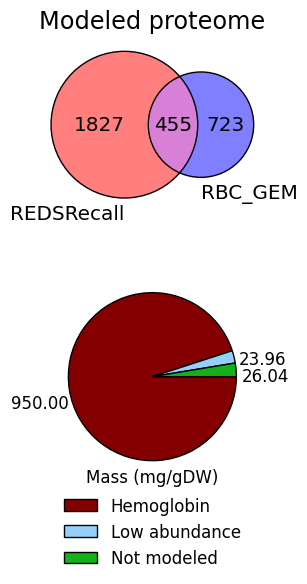

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(3, 6))
subsets = (
    len(dataset_proteins),
    len(model_proteins),
    len(dataset_proteins.intersection(model_proteins)),
)


venn = mpl_venn.venn2(
    subsets=subsets,
    set_labels=(dataset_name, model.id),
    set_colors=("red", "blue"),
    alpha=0.5,
    ax=ax1,
)
circles = mpl_venn.venn2_circles(
    subsets=subsets, linestyle="-", color="black", ax=ax1, linewidth=1
)
for text in venn.set_labels:
    text.set_fontsize("x-large")
for text in venn.subset_labels:
    text.set_fontsize("x-large")
ax1.set_title("Modeled proteome", fontsize="xx-large")


label_color_map = {
    "Mean hemoglobin mass modeled": ("Hemoglobin", "xkcd:dark red"),
    "Mean low abundance mass modeled": ("Low abundance", "xkcd:light blue"),
    "Mean low abundance mass remaining": ("Not modeled", "xkcd:green"),
}
edgecolor = "black"
linewidth = 1
ax2.pie(
    x=proteomes.values,
    colors=[label_color_map[k][1] for k in proteomes.index],
    pctdistance=1.35,
    counterclock=False,
    autopct=lambda pct: f"{pct * 1000/100:.2f}\n",
    textprops=dict(fontsize="large", ha="center", va="top"),
    wedgeprops=dict(edgecolor=edgecolor, linewidth=linewidth),
)
handles = [
    mpl.patches.Patch(
        edgecolor=edgecolor,
        linewidth=linewidth,
        label=label_color_map[k][0],
        facecolor=label_color_map[k][1],
    )
    for k in proteomes.index
]
ax2.legend(
    handles=handles,
    ncols=1,
    bbox_to_anchor=(0.5, 0),
    loc="upper center",
    fontsize="large",
    frameon=False,
)
ax2.set_xlabel("Mass (mg/gDW)", fontsize="large", labelpad=-10)
if save_figures:
    fig.savefig(
        results_dirpath / f"ModeledProteome.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )
fig;

## Create QP model for each sample

In [20]:
def solve_qp(pcmodel, df):
    x = []  # Variables
    c = []  # Data * Weights
    F = []  # Weights

    for protdl, (data_value, weight) in df.iterrows():
        protdl = pcmodel.reactions.get_by_id(protdl)
        x.append(protdl.flux_expression)
        c.append(weight * data_value)
        F.append(weight)

    x = sympy.Matrix(x)
    c = sympy.Matrix(c)
    F = sympy.DiagMatrix(sympy.Matrix(F))
    # # QP Objective must be in form of 0.5 * x.T * F * x - c.T * x
    objective = 0.5 * x.T * F * x - c.T * x
    pcmodel.objective = objective[0]
    pcmodel.objective_direction = "min"
    pcmodel.tolerance = COBRA_CONFIGURATION.tolerance

    qp_sol = pcmodel.optimize()
    return qp_sol

def solve_qp_for_sample(
    pcmodel,
    data_measured,
    data_weights=None,
    log_zero_replacement=1e-9,
    verbose=True,
):
    # Get protein values
    data_measured = data_measured.copy()
    data_measured.name = "Measured"
    if data_weights is None:
        data_weights = pd.Series([1] * len(data_measured), index=list(data_measured.index))
    else:
        data_weights = data_weights.copy()
    data_weights.name = "Weights"
    df_model_protein_dilutions = create_protein_dilution_df(pcmodel)
    # Map to model
    df_model_data = (
        df_model_protein_dilutions[["PROTDL"]]
        .merge(data_measured, left_index=True, right_index=True, how="left")
        .merge(data_weights, left_index=True, right_index=True, how="left")
        .set_index("PROTDL")
        .sort_index()
    )
    # Drop data without mappings
    df = (
        df_model_data.loc[:, [data_measured.name, data_weights.name]]
        .dropna(axis=0, how="all")
        .astype(float)
    )

    # Solve QP
    with pcmodel:
        qp_sol = solve_qp(pcmodel, df)
    df_qp_sol = qp_sol.fluxes.loc[pcmodel.reactions.query(lambda x: isinstance(x, ProteinDilution)).list_attr("id")]
    df_qp_sol = pd.concat((df_model_data.loc[:, data_measured.name], df_qp_sol), axis=1).dropna(how="all", axis=0)
    df_qp_sol = df_qp_sol.rename({data_measured.name: "Measured", "fluxes": "Best-Fitted"}, axis=1)

    # # Fill NA measurements with 0 values for unmeasured model proteins that had a non-zero value in the best-fit. 
    # # Will result in 0 value relaxation budget
    # df = df_qp_sol[df_qp_sol["Best-Fitted"] != 0]
    # df_qp_sol.loc[df[df["Measured"].isna()].index] = df_qp_sol.loc[df[df["Measured"].isna()].index].fillna(0)
    df_qp_sol = df_qp_sol.dropna(how="any", axis=0)

    obj_r2_values = {"Objective": qp_sol.objective_value}
    
    # Calculate R2 score
    df = df_qp_sol.copy()
    obj_r2_values["R^2"] = r2_score(df.iloc[:, 0].values, df.iloc[:, 1].values, multioutput="uniform_average")
    # Calculate R2 score on log10 transformed data
    df = df_qp_sol.apply(lambda x: [log_zero_replacement if np.isclose(y, 0, atol=log_zero_replacement) else y for y in x]).apply(np.log10)
    obj_r2_values["R^2 log10"] = r2_score(df.iloc[:, 0].values, df.iloc[:, 1].values, multioutput="uniform_average")
    # Calculate R2 score on log10 transformed data after removing 'zero' values
    df = df_qp_sol[~df_qp_sol.apply(lambda x: np.isclose(x, 0, atol=log_zero_replacement).any(), axis=1)].apply(np.log10)
    obj_r2_values["R^2 log10 w/o zeros"] = r2_score(df.iloc[:, 0].values, df.iloc[:, 1].values, multioutput="uniform_average")
    handle_msg("\t".join([f"Sample '{sample_id}'"] + [f'{key}: {value:.4f}' for key, value in obj_r2_values.items()] + [f"#zeros: {len(df_qp_sol) - len(df):d}/{len(df_qp_sol):d}"]), print_msg=verbose)
    return (df_qp_sol, obj_r2_values)

### Set weightings for QP problem

In [21]:
# Ensure data is provided as (Protein IDs x Sample IDs)
# Use original copy number values for weights
df_weights = df_copy_numbers.T.loc[df_protein_data.index, df_samples.columns]
df_weights = 1 / df_weights.infer_objects(copy=False).replace(0, 1)
df_weights /= df_weights.mean()
df_weights

,Allele0_C0,Allele0_C1,Allele0_C2,Allele0_C3,Allele0_C4,Allele0_C5,Allele0_C6,Allele0_C7,Allele0_C8,Allele0_C9,...,Allele2_S379_D42,Allele2_S417_D10,Allele2_S417_D23,Allele2_S417_D42,Mean_Allele0,Mean_Allele1,Mean_Allele2,Median_Allele0,Median_Allele1,Median_Allele2
Entry,,,,,,,,,,,,,,,,,,,,,
A0A075B6I0,0.002359,0.002625,0.003849,0.001483,0.001587,0.003734,0.001381,0.000510,0.001872,0.001570,...,0.000025,0.000120,0.000111,0.000036,0.019083,0.001960,0.000085,0.002978,0.000136,0.000032
A0A075B6I9,0.031664,0.037977,0.012155,0.022272,0.052731,0.034866,1.216771,0.010496,0.056737,0.080480,...,4.337472,3.885375,3.696631,3.852742,0.186502,0.010058,10.704753,0.043688,0.000844,4.430900
A0A075B6J9,0.002552,0.002374,0.007021,0.001649,0.000420,0.008435,0.000899,0.000333,0.003750,0.002188,...,0.000787,0.000097,0.000008,3.852742,0.021751,0.001607,0.000091,0.002883,0.000330,0.000195
A0A075B6K4,0.657691,1.113443,2.278965,2.771531,1.955794,0.842248,1.335104,0.437872,10.608397,2.796418,...,4.337472,3.885375,3.696631,3.852742,8.819354,0.259713,10.704753,3.277867,13.044127,4.430900
A0A075B6K5,0.000460,0.000511,0.001397,0.000472,0.000091,0.002076,0.000161,0.000047,0.000437,0.000604,...,0.000008,0.000007,0.000005,0.000006,0.004743,0.000438,0.000019,0.000712,0.000036,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6E0,0.009720,0.018343,0.031927,0.013794,0.004488,0.054063,0.006973,0.002204,0.008980,0.011131,...,0.000330,0.000414,0.000488,0.000337,0.153017,0.015719,0.001116,0.021460,0.001095,0.000454
Q9Y6I3,0.018456,0.061892,0.055547,0.022861,0.028869,0.129252,0.022828,0.023363,0.027459,0.035207,...,0.000481,0.002000,3.696631,0.000548,0.467374,0.052246,0.003285,0.066276,0.005069,0.002524
Q9Y6M4,0.002959,0.004637,0.013805,0.007454,0.002454,0.015914,0.002761,0.006887,0.005753,0.003820,...,4.337472,3.885375,3.696631,3.852742,0.064684,0.005814,0.000066,0.008414,0.000499,4.430900


### Fit data by solving QP

In [22]:
log_zero_replacement = COBRA_CONFIGURATION.tolerance
fitting_data = {"measured": {}, "best_fit": {}, "r2_objective": {}}
qp_solutions_dict = {}
try:
    previous_fitting_data = {key: pd.read_csv(fitting_dirpath / f"proteome_{key}.csv", index_col=0) for key in list(fitting_data)}
except FileNotFoundError:
    # No previous data, reset 
    previous_fitting_data = {key: pd.DataFrame() for key in list(fitting_data)}
if run_computations:
    for sample_id, data_measured in df_samples.items():
        # Key shouldn't matter for checking existance of previous solution
        if not overwrite and sample_id in previous_fitting_data[list(fitting_data)[-1]].columns:
            handle_msg(f"QP solution already obtained for {sample_id}", print_msg=verbose)
            for key, fitting_dict in fitting_data.items():
                fitting_dict[sample_id] = previous_fitting_data[key].loc[:, sample_id].to_dict()

            df_qp_sol = pd.concat(
                (
                    previous_fitting_data["measured"].loc[:, sample_id],
                    previous_fitting_data["best_fit"].loc[:, sample_id],
                ),
                axis=1,
            ).fillna(0)
            df_qp_sol.columns = ["Measured", "Best-Fitted"]
            obj_r2_values = previous_fitting_data["r2_objective"].loc[:, sample_id]
            qp_solutions_dict[sample_id] = (df_qp_sol, obj_r2_values)
        else:
            df_qp_sol, obj_r2_values = solve_qp_for_sample(
                pcmodel,
                data_measured,
                data_weights=df_weights.loc[:, sample_id],
                log_zero_replacement=COBRA_CONFIGURATION.tolerance,
                verbose=verbose,
            )
            fitting_data["measured"][sample_id] = df_qp_sol["Measured"].to_dict()
            fitting_data["best_fit"][sample_id] = df_qp_sol["Best-Fitted"].to_dict()
            fitting_data["r2_objective"][sample_id] = obj_r2_values
            qp_solutions_dict[sample_id] = (df_qp_sol, obj_r2_values)
    # Save solutions to files
    for key, data in fitting_data.items():
        data = pd.DataFrame.from_dict(data, orient="columns")
        data.to_csv(fitting_dirpath / f"proteome_{key}.csv", index=True)
        fitting_data[key] = data
else:
    for key in previous_fitting_data.keys():
        fitting_data[key] = pd.read_csv(fitting_dirpath / f"proteome_{key}.csv", index_col=0)
    if len(df_samples.columns) != len(fitting_data[list(fitting_data)[-1]].columns):
        warn("Number of previous solutions does not match current number of samples! May need to re-run fitting")
    for sample_id in fitting_data[list(fitting_data)[-1]].columns:
        df_qp_sol = pd.concat(
            (
                fitting_data["measured"].loc[:, sample_id],
                fitting_data["best_fit"].loc[:, sample_id],
            ),
            axis=1,
        ).fillna(0)
        df_qp_sol.columns = ["Measured", "Best-Fitted"]
        obj_r2_values = fitting_data["r2_objective"].loc[:, sample_id].to_dict()
        qp_solutions_dict[sample_id] = (df_qp_sol, obj_r2_values)
handle_msg(f"Number of QP solutions: {len(qp_solutions_dict)}", print_msg=verbose)

Sample 'Allele0_C0'	Objective: -336.6466	R^2: 1.0000	R^2 log10: 0.8905	R^2 log10 w/o zeros: 0.9492	#zeros: 4/455
Sample 'Allele0_C1'	Objective: -731.1958	R^2: 1.0000	R^2 log10: 0.8344	R^2 log10 w/o zeros: 0.9359	#zeros: 1/455
Sample 'Allele0_C2'	Objective: -1269.1412	R^2: 1.0000	R^2 log10: 0.9259	R^2 log10 w/o zeros: 0.9259	#zeros: 0/455
Sample 'Allele0_C3'	Objective: -479.6955	R^2: 1.0000	R^2 log10: 0.7296	R^2 log10 w/o zeros: 0.7581	#zeros: 3/455
Sample 'Allele0_C4'	Objective: -165.5927	R^2: 1.0000	R^2 log10: 0.8948	R^2 log10 w/o zeros: 0.9398	#zeros: 5/455
Sample 'Allele0_C5'	Objective: -2080.1147	R^2: 1.0000	R^2 log10: 0.9212	R^2 log10 w/o zeros: 0.9212	#zeros: 0/455
Sample 'Allele0_C6'	Objective: -278.7017	R^2: 1.0000	R^2 log10: 0.8573	R^2 log10 w/o zeros: 0.9191	#zeros: 3/455
Sample 'Allele0_C7'	Objective: -98.2548	R^2: 1.0000	R^2 log10: 0.9165	R^2 log10 w/o zeros: 0.9433	#zeros: 8/455
Sample 'Allele0_C8'	Objective: -367.4992	R^2: 1.0000	R^2 log10: 0.8386	R^2 log10 w/o zeros: 0.9

### Plot fitting 
#### For the mean and median samples of each time point and for each chosen genotype

In [23]:
samples_to_plot = np.array(
    [
        
        [
            x
            for x in operation_ids if operation_re.search(x).group("op") == "Mean"
                                                                                                  
        ],
        [
            x
            for x in operation_ids if operation_re.search(x).group("op") == "Median"
        ],
    ]
).T
samples_to_plot;

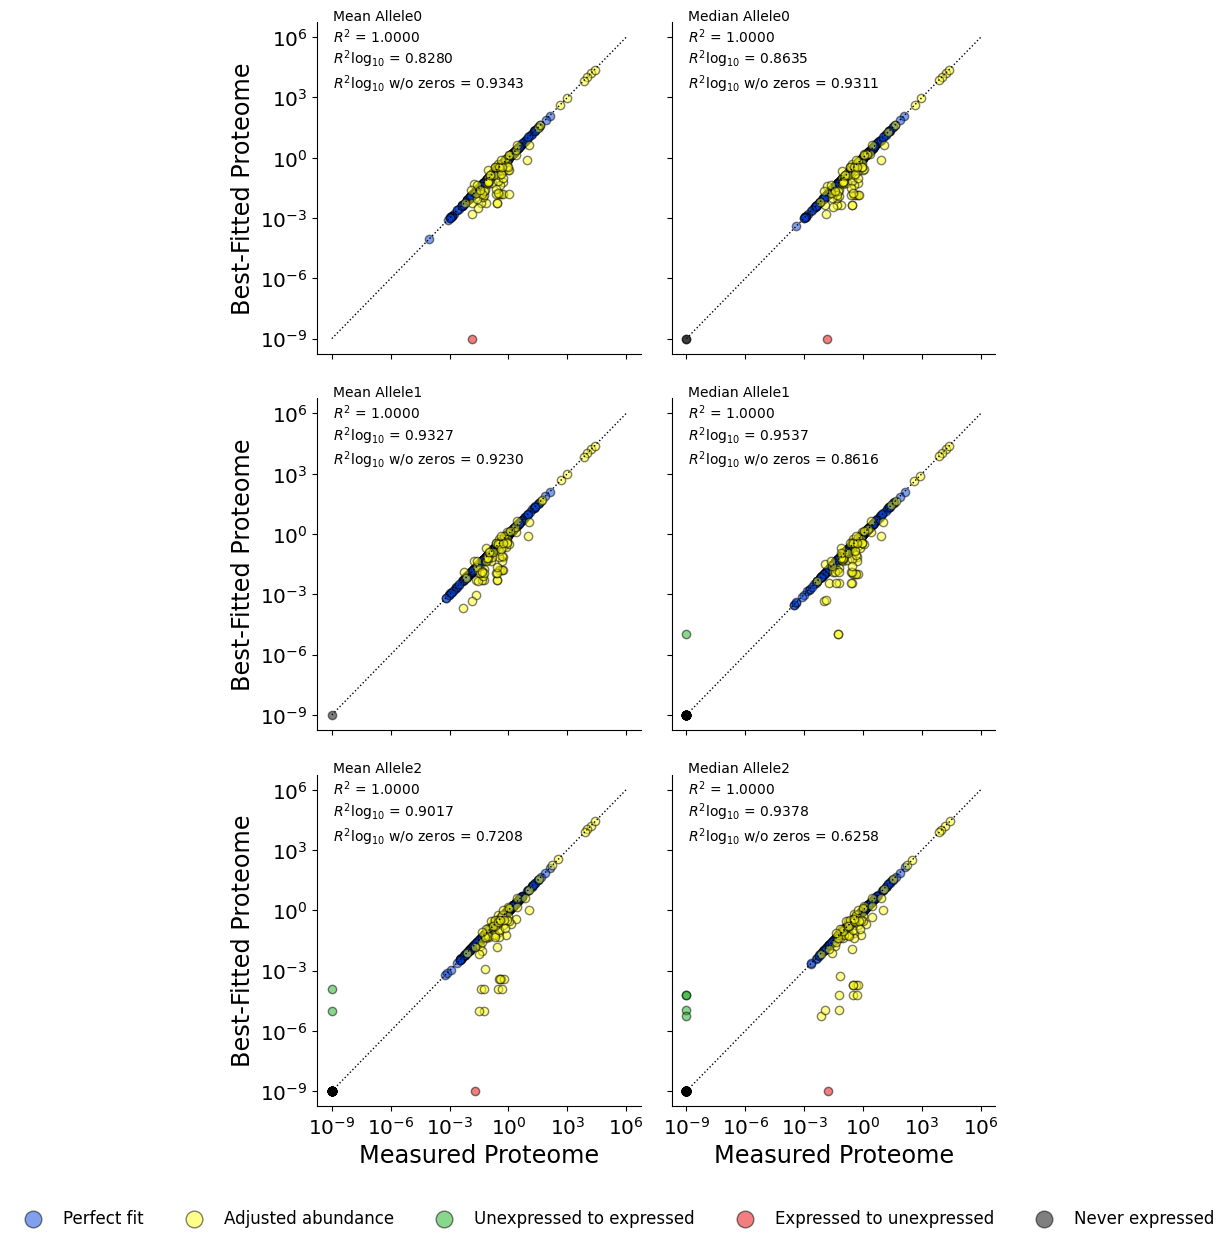

In [24]:
r2_text_loc = "upper left"
transform = False

length = 4
nrows, ncols = samples_to_plot.shape
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(length * ncols, length * nrows),
    sharex=True,
    sharey=True,
)
sns.despine(fig)
for idx, (sample_id, ax) in enumerate(zip(samples_to_plot.flatten(), axes.flatten())):
    df_qp_sol, obj_r2_values = qp_solutions_dict[sample_id]
    # Copy to prevent alterations to the original
    df_qp_sol = df_qp_sol.copy()
    xlabel, ylabel = df_qp_sol.columns

    ticks = 10 ** np.arange(np.log10(log_zero_replacement), -np.log10(log_zero_replacement), 3)
    if transform:
        ticks = np.log10(ticks)
        df_qp_sol.iloc[:, 0] = (
            df_qp_sol.iloc[:, 0]
            .apply(lambda x: log_zero_replacement if np.isclose(x, 0, atol=log_zero_replacement) else x)
            .apply(np.log10)
        )
        df_qp_sol.iloc[:, 1] = (
            df_qp_sol.iloc[:, 1]
            .apply(lambda x: log_zero_replacement if np.isclose(x, 0, atol=log_zero_replacement) else x)
            .apply(np.log10)
        )
    perfect_fit_line = ax.plot(
        [ticks[0], ticks[-1]],
        [ticks[0], ticks[-1]],
        linestyle=":",
        color="black",
        linewidth=1,
        alpha=1,
    )
    zero_val = 0 if not transform else np.log10(log_zero_replacement)

    df_zeros = df_qp_sol[(df_qp_sol.apply(lambda x: np.isclose(x, zero_val, atol=log_zero_replacement))).any(axis=1)]
    df_perfect = df_qp_sol[np.isclose(abs(df_qp_sol["Measured"] - df_qp_sol["Best-Fitted"]), 0, atol=log_zero_replacement)]
    df_perfect = df_perfect[~df_perfect.index.isin(df_zeros.index)]

    df_altered = df_qp_sol[~np.isclose(abs(df_qp_sol["Measured"] - df_qp_sol["Best-Fitted"]), 0, atol=log_zero_replacement)]
    df_altered = df_altered[~df_altered.index.isin(df_zeros.index)]
    df_always_zero = df_zeros[(df_zeros == zero_val).all(axis=1)]
    df_zeros = df_zeros[~df_zeros.index.isin(df_always_zero.index)]
    df_from_zeros = df_zeros[np.isclose(df_zeros["Measured"], zero_val, atol=log_zero_replacement)]
    df_to_zeros = df_zeros[np.isclose(df_zeros["Best-Fitted"], zero_val, atol=log_zero_replacement)]

    handles = [
        ax.scatter(
            data=df_perfect.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:blue",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
        ax.scatter(
            data=df_altered.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:yellow",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
        ax.scatter(
            data=df_from_zeros.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:green",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
        ax.scatter(
            data=df_to_zeros.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:red",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
        ax.scatter(
            data=df_always_zero.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:black",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
    ]
    labels = [
        f"Perfect fit",
        f"Adjusted abundance",
        f"Unexpressed to expressed",
        f"Expressed to unexpressed",
        f"Never expressed",
    ]

    sample_label = str(sample_id.replace(f"{pcmodel.id}_", "").replace("_", " "))
    if not transform:
        ax.set_xscale("log")
        ax.set_yscale("log")
    fontdict = {"size": "xx-large"}
    if idx >= len(samples_to_plot.flatten()) - ncols:
        ax.set_xlabel(f"{xlabel} Proteome", fontdict=fontdict)
    if idx % ncols == 0:
        ax.set_ylabel(f"{ylabel} Proteome", fontdict=fontdict)

    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    ax.xaxis.set_tick_params(labelsize="x-large")
    ax.yaxis.set_tick_params(labelsize="x-large")

    r2_format = " = {:.4f}"
    r2_pos_dict = {"lower right": ((0.95, 1), "right"), "upper left": ((0.05, 0.8), "left")}
    if r2_text_loc in r2_pos_dict:
        pos, ha = r2_pos_dict[r2_text_loc]
        ax.text(
            *pos,
            "\n".join(
                (
                    sample_label,
                    r"$R^{2}$" + r2_format.format(obj_r2_values["R^2"]),
                    r"$R^{2}\text{log}_{10}$"
                    + r2_format.format(obj_r2_values["R^2 log10"]),
                    r"$R^{2}\text{log}_{10}\text{ w/o zeros}$"
                    + r2_format.format(obj_r2_values["R^2 log10 w/o zeros"]),
                )
            ),
            transform=ax.transAxes,
            color="black",
            fontsize="medium",
            ha=ha,
        )
fig.legend(
    handles=handles,
    labels=labels,
    loc="upper center",
    ncols=len(labels),
    frameon=False,
    fontsize="large",
    markerscale=2,
    bbox_to_anchor=(0.5, -0.01),
)
fig.tight_layout()
if save_figures:
    fig.savefig(
        fitting_dirpath
        / f"QPfitting_{'' if not transform else 'log10_'}{model_id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

### Determine best value for slack variable

In [25]:
slack_determination_models = samples_to_plot.flatten()

if run_computations:
    list_of_pcmodels = []
    for sample_id in slack_determination_models:
        df_qp_sol, _ = qp_solutions_dict[sample_id]
        # Create a copy of the model
        pcmodel_sample = pcmodel.copy()
        pcmodel_sample.id = f"{pcmodel.id}_{sample_id}"
        for protdl in pcmodel_sample.reactions.query(
            lambda x: isinstance(x, ProteinDilution)
        ):
            if protdl.id in df_qp_sol.index:
                prot_bound = df_qp_sol.loc[protdl.id]["Best-Fitted"]
            else:
                prot_bound = 0
            protdl.bounds = (float(prot_bound), float(prot_bound))
        # Add the relaxation budget with slack = 0 first
        add_relaxation_budget(pcmodel_sample, 0, int(verbose))
        list_of_pcmodels += [pcmodel_sample]

Relaxation budget added to RBC_GEM_PC_Mean_Allele0, extra 0.0000 mg/gDW (0.0000 mg HB/gDW) from 0.0000% slack
Relaxation budget added to RBC_GEM_PC_Median_Allele0, extra 0.0000 mg/gDW (0.0000 mg HB/gDW) from 0.0000% slack
Relaxation budget added to RBC_GEM_PC_Mean_Allele1, extra 0.0000 mg/gDW (0.0000 mg HB/gDW) from 0.0000% slack
Relaxation budget added to RBC_GEM_PC_Median_Allele1, extra 0.0000 mg/gDW (0.0000 mg HB/gDW) from 0.0000% slack
Relaxation budget added to RBC_GEM_PC_Mean_Allele2, extra 0.0000 mg/gDW (0.0000 mg HB/gDW) from 0.0000% slack
Relaxation budget added to RBC_GEM_PC_Median_Allele2, extra 0.0000 mg/gDW (0.0000 mg HB/gDW) from 0.0000% slack


In [26]:
slack_min = 1e-5  # Slack %
slack_max = 1.5
if run_computations:
    solutions = {
        pcmodel_sample.id: defaultdict(list) for pcmodel_sample in list_of_pcmodels
    }
    for slack_value in np.geomspace(slack_min, slack_max, 101):
        handle_msg(f"Updating slack variable to {slack_value:.6f}.", print_msg=verbose)
        for pcmodel_sample in list_of_pcmodels:
            update_slack_value(pcmodel_sample, slack_value, verbose=False)
            budget_rxn_relaxation = pcmodel_sample.reactions.get_by_id(f"{budget_rxn_prefix}{budget_met_prefix}relaxation")
            pcmodel_sample.objective = (
                sum(
                    [
                        r.flux_expression
                        for r in pcmodel_sample.reactions.get_by_any(
                            objective_reactions
                        )
                    ]
                )
                - budget_rxn_relaxation.flux_expression
            )
            pcmodel_sample.objective_direction = "max"
            sol = pcmodel_sample.optimize()
            obj_value = sol.objective_value
            if not obj_value or np.isnan(obj_value):
                handle_msg(f"No solution at s = {slack_value:.6f} for model {pcmodel_sample}", print_msg=bool(int(verbose) > 1))
                continue
            else:
                demand = budget_rxn_relaxation.flux
                budget = budget_rxn_relaxation.upper_bound
            solutions[pcmodel_sample.id]["model"].append(pcmodel_sample.id)
            solutions[pcmodel_sample.id]["slack"].append(slack_value)
            solutions[pcmodel_sample.id]["objective"].append(obj_value)
            if objective_reactions:
                solutions[pcmodel_sample.id]["_".join(objective_reactions)].append(sol.fluxes.loc[objective_reactions].sum())
            solutions[pcmodel_sample.id]["relaxation_used_mg_per_gDW"].append(demand)
            solutions[pcmodel_sample.id]["relaxation_budget"].append(budget)
            solutions[pcmodel_sample.id]["relaxation_used_pct"].append(demand / budget * 100)
    solutions = {
        pcmodel_sample_id: pd.DataFrame.from_dict(sol)
        for pcmodel_sample_id, sol in solutions.items()
    }
    df_relaxation = pd.concat(list(solutions.values()), axis=0)
    df_relaxation.to_csv(
        fitting_dirpath / f"SlackPercentDeterminationData_{model_id}.csv",
        index=False,
    )
else:
    df_relaxation = pd.read_csv(
        fitting_dirpath / f"SlackPercentDeterminationData_{model_id}.csv",
    )
    solutions = {
        mid: df_relaxation[df_relaxation["model"] == mid].drop("model", axis=1)
        for mid in df_relaxation["model"].unique()
    }
df_relaxation

Updating slack variable to 0.000010.


C:\Users\P7875\miniconda3\envs\memote-rbc-gem\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Updating slack variable to 0.000011.
Updating slack variable to 0.000013.
Updating slack variable to 0.000014.
Updating slack variable to 0.000016.
Updating slack variable to 0.000018.
Updating slack variable to 0.000020.
Updating slack variable to 0.000023.
Updating slack variable to 0.000026.
Updating slack variable to 0.000029.
Updating slack variable to 0.000033.
Updating slack variable to 0.000037.
Updating slack variable to 0.000042.
Updating slack variable to 0.000047.
Updating slack variable to 0.000053.
Updating slack variable to 0.000060.
Updating slack variable to 0.000067.
Updating slack variable to 0.000076.
Updating slack variable to 0.000085.
Updating slack variable to 0.000096.
Updating slack variable to 0.000108.
Updating slack variable to 0.000122.
Updating slack variable to 0.000138.
Updating slack variable to 0.000155.
Updating slack variable to 0.000175.
Updating slack variable to 0.000197.
Updating slack variable to 0.000222.
Updating slack variable to 0.000250.
U

,model,slack,objective,relaxation_used_mg_per_gDW,relaxation_budget,relaxation_used_pct
0,RBC_GEM_PC_Mean_Allele0,0.020545,-0.830000,0.830000,20.000935,4.149808
1,RBC_GEM_PC_Mean_Allele0,0.023145,-0.822604,0.822604,22.532595,3.650728
2,RBC_GEM_PC_Mean_Allele0,0.026075,-0.813551,0.813551,25.384705,3.204887
3,RBC_GEM_PC_Mean_Allele0,0.029375,-0.809309,0.809309,28.597827,2.829967
4,RBC_GEM_PC_Mean_Allele0,0.033093,-0.806069,0.806069,32.217657,2.501947
...,...,...,...,...,...,...
30,RBC_GEM_PC_Median_Allele2,0.578101,-0.200585,0.200585,562.545491,0.035657
31,RBC_GEM_PC_Median_Allele2,0.651276,-0.164283,0.164283,633.750859,0.025922
32,RBC_GEM_PC_Median_Allele2,0.733712,-0.123387,0.123387,713.969194,0.017282
33,RBC_GEM_PC_Median_Allele2,0.826583,-0.077314,0.077314,804.341332,0.009612


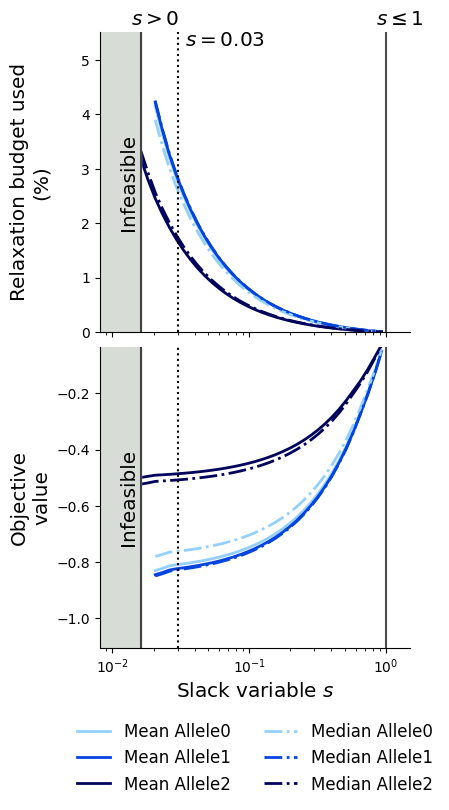

In [27]:
chosen_slack_var = 0.03
colors = {"0": "xkcd:light blue", "1": "xkcd:blue", "2": "xkcd:dark blue"}
colors = {k: colors.get(k[-1], "xkcd:black") for k in [pcmodel_sample.replace(f"{pcmodel.id}_", "").split("_", maxsplit=1)[-1] for pcmodel_sample in list(solutions)]}

linestyles = {
    "Mean": "-",
    "Median": "-.",
}
nrows = 3 if objective_reactions else 2
fig, axes = plt.subplots(
    nrows, 1, figsize=(4, nrows * 4), sharex=True, gridspec_kw=dict(hspace=0.05)
)
axes = axes.flatten()
sns.despine(fig)
o_values_min_max = (1000, -1000)
r_values_max = -1000
rxn_values_min_max = (0, -1000)

for pcmodel_sample in list(sorted(list(solutions))):
    op, group = pcmodel_sample.replace(f"{pcmodel.id}_", "").split("_", maxsplit=1)
    color = colors.get(group, "xkcd:black")
    linestyle = linestyles.get(op, ":")
    s_values = solutions[str(pcmodel_sample)]["slack"].values
    r_values = solutions[str(pcmodel_sample)]["relaxation_used_pct"].values
    o_values = solutions[str(pcmodel_sample)]["objective"].values
    r_values_max = max(r_values.max(), r_values_max)
    o_values_min_max = (min(o_values.min(), o_values_min_max[0]), max(o_values.max(), o_values_min_max[-1]),)

    zorder = 1
    lw = 2
    axes[0].plot(
        s_values,
        r_values,
        label=str(pcmodel_sample),
        color=color,
        linestyle=linestyle,
        linewidth=lw,
        zorder=zorder,
    )
    axes[1].plot(
        s_values,
        o_values,
        label=str(pcmodel_sample),
        color=color,
        linestyle=linestyle,
        linewidth=lw,
        zorder=zorder,
    )
    if objective_reactions:
        rxn_values = solutions[str(pcmodel_sample)]["_".join(objective_reactions)].values
        rxn_values_min_max = (min(rxn_values, rxn_values_min_max[0]), max(rxn_values, rxn_values_min_max[-1]),)

        axes[2].plot(
            s_values,
            rxn_values,
            label=str(pcmodel_sample),
            color=color,
            linestyle=linestyle,
            linewidth=lw,
            zorder=zorder,
        )

fontdict = {"size": "x-large"}
axes[-1].set_xlabel(r"Slack variable $s$", fontdict=fontdict)

zorder = 2
alpha = 0.7
limit_pad_sclar = 1.3
smin = s_values[0]

for i, ax in enumerate(axes):
    if i == 0:
        ymin, ymax = (-0.001, r_values_max * limit_pad_sclar)
    elif i == 1:
        ymin, ymax = (min(0, o_values_min_max[0]) * limit_pad_sclar, o_values_min_max[-1] * limit_pad_sclar)
    elif i == 2:
        ymin, ymax = (rxn_values_min_max[0] * limit_pad_sclar, rxn_values_min_max[-1])
    else:
        pass
    ax.vlines(chosen_slack_var, ymin=ymin, ymax=ymax, color="black", linestyle=":")
    ax.vlines(
        smin,
        ymin=ymin,
        ymax=ymax,
        color="black",
        linestyle="-",
        zorder=zorder,
        alpha=alpha,
    )
    ax.vlines(
        1,
        ymin=ymin,
        ymax=ymax,
        color="black",
        linestyle="-",
        zorder=zorder,
        alpha=alpha,
    )
    xmin = smin / 2
    ax.set_xlim(xmin, slack_max)
    ax.set_ylim(ymin, ymax)
    ax.set_xscale("log")
    if i == 0:
        ax.annotate(
            rf"$s > 0$",
            xy=(smin, ymax),
            xycoords="data",
            xytext=(10, 5),
            textcoords="offset points",
            ha="center",
            fontsize=fontdict["size"],
        )
        ax.annotate(
            rf"$s \leq 1$",
            xy=(1, ymax),
            xycoords="data",
            xytext=(10, 5),
            textcoords="offset points",
            ha="center",
            fontsize=fontdict["size"],
        )
        ax.annotate(
            rf"$s = {chosen_slack_var}$",
            xy=(chosen_slack_var, ymax),
            xycoords="data",
            xytext=(5, -10),
            textcoords="offset points",
            ha="left",
            fontsize=fontdict["size"],
        )
    ax.fill_between((xmin, smin), ymin, ymax, color="xkcd:light grey")
    ax.annotate(
        "Infeasible",
        xy=(smin, (ymax + ymin) / 2),
        xycoords="data",
        rotation=90,
        xytext=(-2, 0),
        textcoords="offset points",
        va="center",
        ha="right",
        fontsize=fontdict["size"],
    )


handles, labels = axes[-1].get_legend_handles_labels()
handles_labels = dict(zip(labels, handles))
labels = [label.replace(f"{pcmodel.id}_", "").replace("_", " ") for label in labels]
axes[-1].legend(
    handles=handles,
    labels=labels,
    ncols=2,
    frameon=False,
    loc="upper center",
    fontsize="large",
    bbox_to_anchor=(0.5, -0.2),
)


axes[0].set_ylabel("Relaxation budget used\n(%)", fontdict=fontdict)
axes[1].set_ylabel("Objective\nvalue", fontdict=fontdict)
if objective_reactions:
    axes[2].set_ylabel(f"{'+'.join(objective_reactions)}\n(mmol/gDW/hr)", fontdict=fontdict)

fig.align_labels()
if save_figures:
    fig.savefig(
        fitting_dirpath / f"SlackPercentDetermination_{model_id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

### Formulate models from QP solutions

In [28]:
ftypes = {
    "xml"
    # "json",
}
slack_value = chosen_slack_var  # Slack %
ftypes = set([ftypes]) if isinstance(ftypes, str) else set(ftypes)
zip_kwargs = dict(
    compression=zipfile.ZIP_DEFLATED,
    compresslevel=None
)


sample_pcmodels_dirpath.mkdir(exist_ok=True, parents=True)
existing_files = []
if not overwrite:
    # Check zip file for existing models
    if Path(f"{sample_pcmodels_dirpath}.zip").exists():
        with zipfile.ZipFile(f"{sample_pcmodels_dirpath}.zip", 'r') as zfile:
            existing_files += [Path(x).name for x in zfile.namelist() if x]
    existing_files += [x.name for x in list(sample_pcmodels_dirpath.iterdir())]

# Check sample directory for existing files
if not len(existing_files) == len(set(existing_files)):
    raise ValueError(f"Duplicates found: {[k for k, v in Counter(existing_files).items() if v > 1]}")
existing_files = set(sorted(existing_files))


for sample_id, (df_qp_sol, _) in qp_solutions_dict.items():
    sample_id = f"{pcmodel.id}_{sample_id}"
    filenames = [f"{sample_id}.{ftype}" for ftype in ftypes]
    if all([fname in existing_files for fname in filenames]):
        handle_msg(f"Model(s) already created for {sample_id}", print_msg=verbose)
        continue
    pcmodel_sample = pcmodel.copy()
    pcmodel_sample.id = sample_id
    for protdl in pcmodel_sample.reactions.query(lambda x: isinstance(x, ProteinDilution)):
        prot_bound = df_qp_sol.loc[protdl.id]["Best-Fitted"] if protdl.id in df_qp_sol.index else 0
        protdl.bounds = (float(prot_bound), float(prot_bound))

    # Add the relaxation budget
    add_relaxation_budget(pcmodel_sample, slack_value, verbose=False)
    budget_rxn_relaxation = pcmodel_sample.reactions.get_by_id(f"{budget_rxn_prefix}{budget_met_prefix}relaxation")
    # Determine smallest allowable relxation budget for simulation capabilities
    with pcmodel_sample:
        pcmodel_sample.objective = budget_rxn_relaxation.flux_expression
        pcmodel_sample.objective_direction = "min"
        budget_min = pcmodel_sample.slim_optimize()
    budget_rxn_relaxation.lower_bound = budget_min
    for filename in filenames:
        # Might as well overwrite all files, especially if model needed to be regenerated anyways
        write_cobra_model(
            pcmodel_sample,
            filename=sample_pcmodels_dirpath / filename,
        )
  
    handle_msg(f"Model(s) saved for {pcmodel_sample.id}", print_msg=verbose)

dirpath = sample_pcmodels_dirpath
with tempfile.TemporaryDirectory() as tmpdir:
    if not overwrite and Path(f"{dirpath}.zip").exists():
        handle_msg("Copying original zip to temporary directory", print_msg=verbose)
        shutil.copy(f"{dirpath}.zip", tmpdir)
    handle_msg("Appending model files to temporary zip file", print_msg=verbose)
    with zipfile.ZipFile(f"{tmpdir}/{dirpath.name}.zip", 'a', **zip_kwargs) as zfile:
        existing_files = set([Path(x).name for x in zfile.namelist() if x])
        for filename in list(dirpath.iterdir()):
            if filename.name in existing_files:
                continue
            zfile.write(f"{filename}", arcname=f"{filename.name}")
    # Replacing original directory
    handle_msg("Setting temporary zip file as the new zip file", print_msg=verbose)
    shutil.copy(f"{tmpdir}/{dirpath.name}.zip", dirpath.parent)
handle_msg("Finished compression, cleaning up files", print_msg=verbose)
shutil.rmtree(str(dirpath))
handle_msg("Finished cleanup", print_msg=verbose)

Model(s) saved for RBC_GEM_PC_Allele0_C0
Model(s) saved for RBC_GEM_PC_Allele0_C1
Model(s) saved for RBC_GEM_PC_Allele0_C2
Model(s) saved for RBC_GEM_PC_Allele0_C3
Model(s) saved for RBC_GEM_PC_Allele0_C4
Model(s) saved for RBC_GEM_PC_Allele0_C5
Model(s) saved for RBC_GEM_PC_Allele0_C6
Model(s) saved for RBC_GEM_PC_Allele0_C7
Model(s) saved for RBC_GEM_PC_Allele0_C8
Model(s) saved for RBC_GEM_PC_Allele0_C9
Model(s) saved for RBC_GEM_PC_Allele0_C10
Model(s) saved for RBC_GEM_PC_Allele0_C11
Model(s) saved for RBC_GEM_PC_Allele0_C12
Model(s) saved for RBC_GEM_PC_Allele0_C13
Model(s) saved for RBC_GEM_PC_Allele0_C14
Model(s) saved for RBC_GEM_PC_Allele0_C15
Model(s) saved for RBC_GEM_PC_Allele0_C16
Model(s) saved for RBC_GEM_PC_Allele0_C17
Model(s) saved for RBC_GEM_PC_Allele1_C18
Model(s) saved for RBC_GEM_PC_Allele1_C19
Model(s) saved for RBC_GEM_PC_Allele1_C20
Model(s) saved for RBC_GEM_PC_Allele1_C21
Model(s) saved for RBC_GEM_PC_Allele1_C22
Model(s) saved for RBC_GEM_PC_Allele1_C23
Mo